In [1]:
import warnings

warnings.filterwarnings("ignore")
import os

if "jbook" in os.getcwd():
    os.chdir(os.path.abspath(os.path.join("../..")))

In [2]:
import matplotlib.pyplot as plt

from explorify.eda.visualize.visualizer import Visualizer
from genailab.setup import auto_wire_container
from genailab.core.dtypes import DFType
from genailab.infra.utils.file.fileset import FileFormat
from genailab.core.flow import PhaseDef, StageDef
from genailab.flow.dataprep.tqa import TQA_FEATURES
# Wire container and obtain the repository
container = auto_wire_container()
repo = container.io.repo()
viz = Visualizer()


# Exploratory Data Analysis

## **Introduction**  
Text quality plays a crucial role in determining the utility of textual data for downstream applications such as model training, evaluation, and content curation. In this analysis, we explore a **Text Quality Assessment (TQA) score**, a metric designed to quantify the linguistic quality of text based on structural and lexical features. The goal of this **Exploratory Data Analysis (EDA)** is to evaluate the distribution, reliability, and interpretability of the TQA score to inform **instance selection**—ensuring that only high-quality reviews are retained for further use.  

## **Research Questions**  
This EDA seeks to answer the following key questions:  

1. **How is text quality distributed across the dataset?**  
   - What is the statistical distribution of TQA scores?  
   - Are there natural groupings or separations in quality levels?  

2. **Which linguistic features most strongly correlate with TQA?**  
   - Do structural elements (e.g., noun phrase count, verb phrase count) influence the score?  
   - How do lexical measures (e.g., review length, dependency depth) relate to TQA?  

3. **Are there meaningful thresholds for selecting high-quality text?**  
   - Can we define a cutoff for high vs. low-quality instances?  
   - Are extreme values (very high or very low TQA) valid indicators of text quality?  

4. **Is the TQA score consistent and reliable?**  
   - Does TQA behave as expected across different categories of text?  
   - Are there anomalies where high-quality text is rated poorly or vice versa?  

## **Approach**  
To systematically answer these questions, we will conduct the following analyses:  

- **Descriptive Statistics & Distribution Analysis:**  
  - Visualizing the overall distribution of TQA scores using histograms and KDE plots.  
  - Examining summary statistics (mean, variance, skewness) to assess score spread.  

- **Feature-Quality Relationships:**  
  - Computing correlations between TQA and linguistic features.  
  - Using scatterplots and feature importance analysis to identify key drivers of TQA.  

- **Threshold Identification & Instance Selection Criteria:**  
  - Identifying quantile-based selection thresholds for high-quality text.  
  - Exploring classification methods (e.g., clustering, outlier detection) to validate separation.  

- **Robustness & Bias Check:**  
  - Analyzing TQA across different review types and lengths to check for biases.  
  - Verifying whether TQA aligns with intuitive expectations of text quality.  

This EDA will ultimately **validate the effectiveness of the TQA score** in differentiating text quality levels and guide **instance selection** for further processing.

## Data

In [3]:
asset_id = repo.get_asset_id(phase=PhaseDef.DATAPREP, stage=StageDef.SENTIMENT, name="review", )
dataset = repo.get(asset_id=asset_id)

In [4]:
dataset.summary



                            AppVoCAI Dataset Summary                            
                             Data Preparation Phase                             
                            Sentiment Analysis Stage                            
                       Number of Reviews | 4,812
                     Number of Reviewers | 4,811
              Number of Repeat Reviewers | 1 (0.0%)
         Number of Influential Reviewers | 294 (6.1%)
                          Number of Apps | 1,866
                 Average Reviews per App | 2.6
                    Number of Categories | 14
                                Features | 24
                       Min Review Length | 3
                       Max Review Length | 492
                   Average Review Length | 37.39
                        Memory Size (Mb) | 3.42
                    Date of First Review | 2021-01-01 02:20:30+00:00
                     Date of Last Review | 2023-08-30 12:49:02+00:00


In [5]:
dataset.profile

,Column,DataType,Complete,Null,Completeness,Unique,Duplicate,Uniqueness,Size (Bytes)
0,id,string[python],4812,0,1.0,4812,0,1.000000,322866
1,app_id,string[python],4812,0,1.0,1866,2946,0.387781,320011
2,app_name,string[python],4812,0,1.0,1866,2946,0.387781,384993
3,category_id,category,4812,0,1.0,14,4798,0.002909,6222
4,author,string[python],4812,0,1.0,4811,1,0.999792,370524
5,rating,Int16,4812,0,1.0,5,4807,0.001039,14436
6,content,string[python],4812,0,1.0,4809,3,0.999377,1198458
7,vote_sum,Int64,4812,0,1.0,13,4799,0.002702,43308
8,vote_count,Int64,4812,0,1.0,17,4795,0.003533,43308
9,date,"datetime64[ns, UTC]",4812,0,1.0,4812,0,1.000000,38496


## TQA Score Distribution

<Axes: title={'center': 'Tqa Score'}, xlabel='tqa_score', ylabel='Density'>

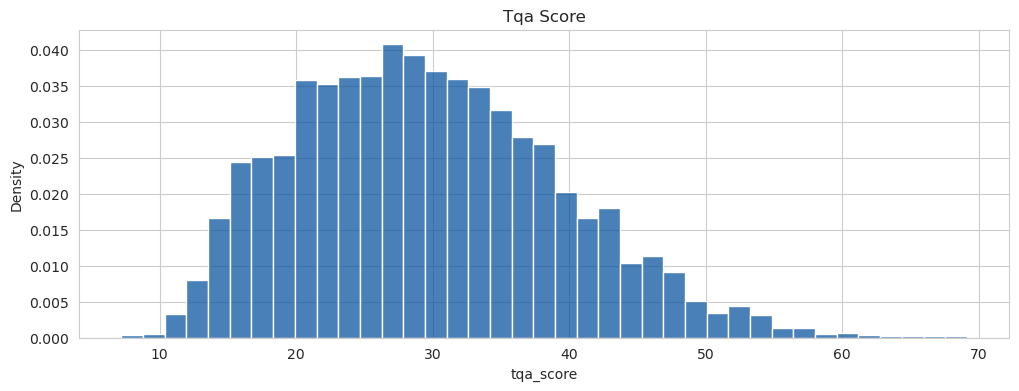

In [6]:
viz.histogram(data=dataset.dataframe, x="tqa_score")

<Axes: title={'center': 'Tqa Score'}, xlabel='tqa_score'>

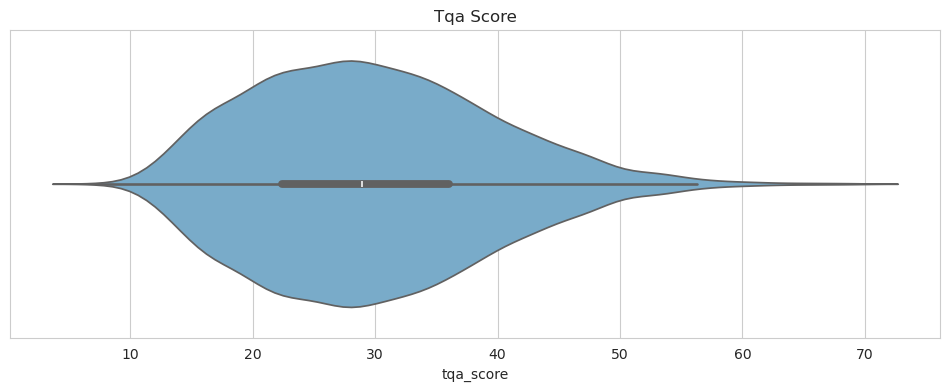

In [7]:
viz.violinplot(data=dataset.dataframe, x="tqa_score")

## Parts of Speech Counts

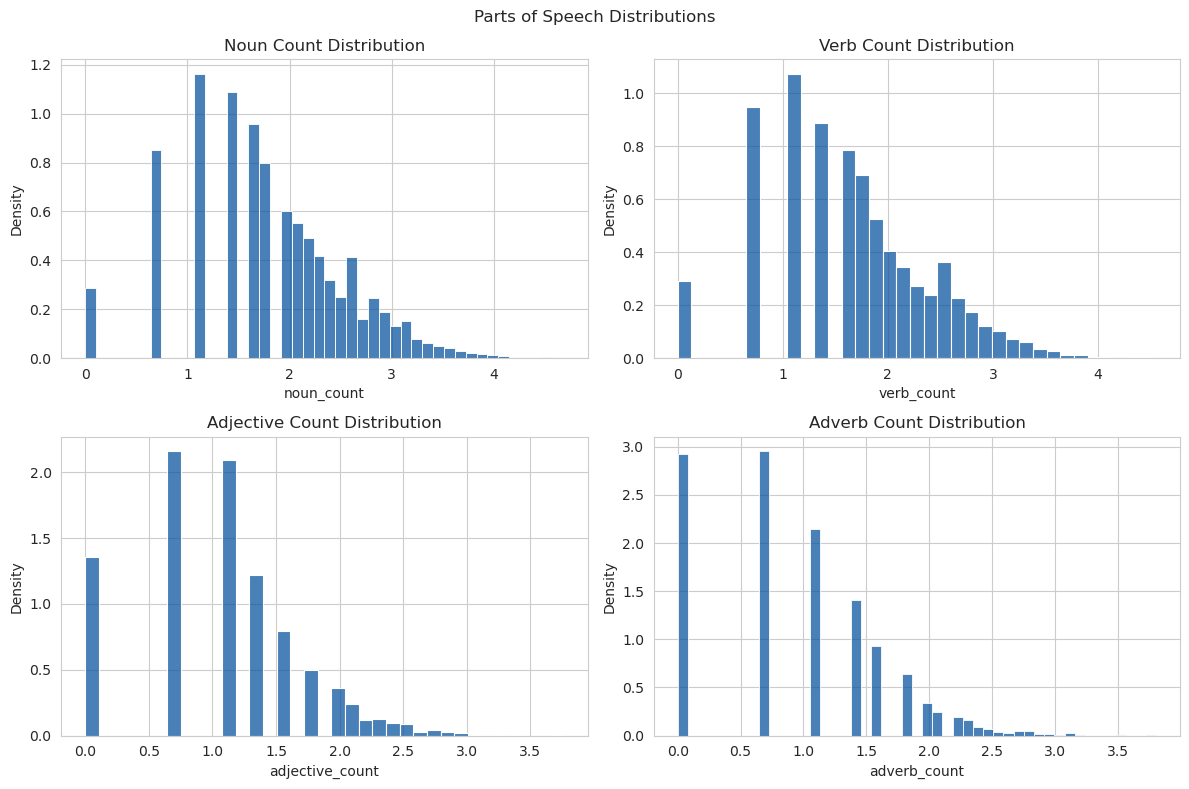

In [12]:
f, ax = plt.subplots(nrows=2,ncols=2, figsize=(12,8))
ax[0,0] = viz.histogram(data=tqa, x="noun_count", ax=ax[0,0], title="Noun Count Distribution")
ax[0,1]= viz.histogram(data=tqa, x="verb_count", ax=ax[0,1], title="Verb Count Distribution")
ax[1,0] = viz.histogram(data=tqa, x="adjective_count", ax=ax[1,0], title="Adjective Count Distribution")
ax[1,1] = viz.histogram(data=tqa, x="adverb_count", ax=ax[1,1], title="Adverb Count Distribution")
f.suptitle(t="Parts of Speech Distributions")
plt.tight_layout()


## Phrase Counts

## Phrase Counts

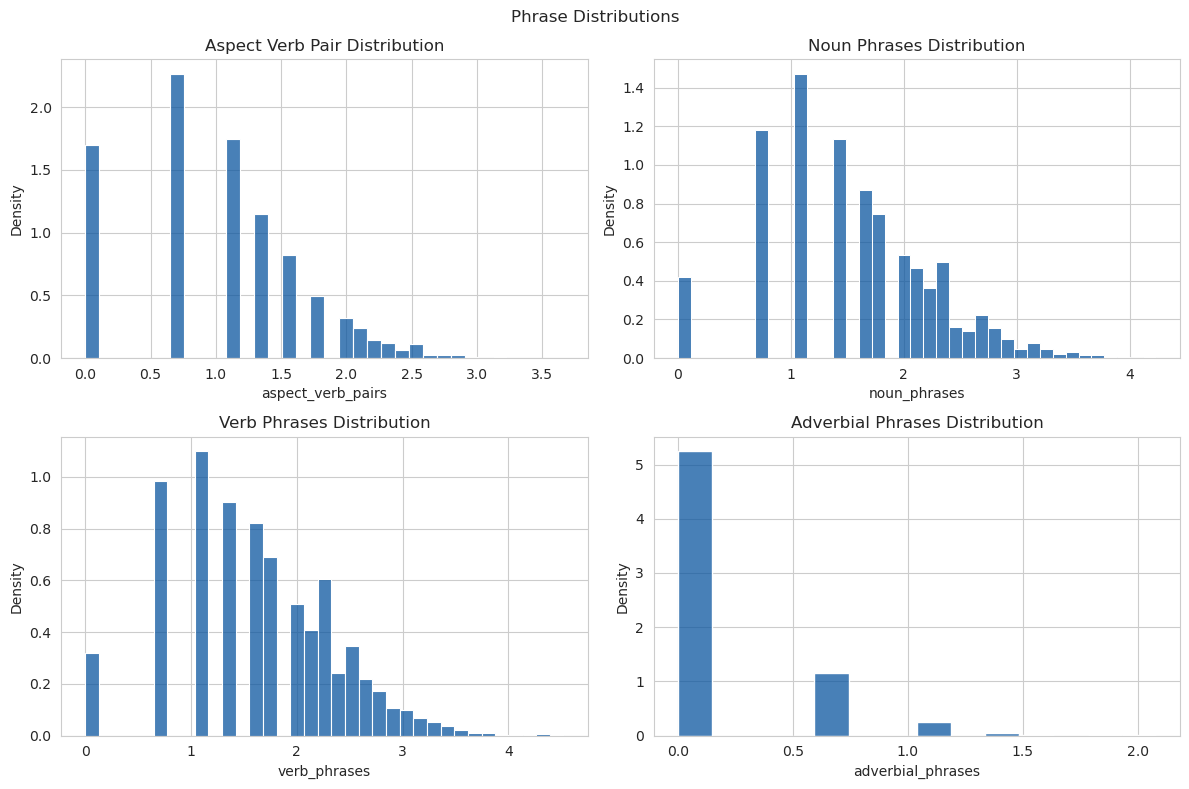

In [ ]:
f, ax = plt.subplots(nrows=2,ncols=2, figsize=(12,8))
ax[0,0] = viz.histogram(data=tqa, x="aspect_verb_pairs", ax=ax[0,0], title="Aspect Verb Pair Distribution")
ax[0,1]= viz.histogram(data=tqa, x="noun_phrases", ax=ax[0,1], title="Noun Phrases Distribution")
ax[1,0] = viz.histogram(data=tqa, x="verb_phrases", ax=ax[1,0], title="Verb Phrases Distribution")
ax[1,1] = viz.histogram(data=tqa, x="adverbial_phrases", ax=ax[1,1], title="Adverbial Phrases Distribution")
f.suptitle(t="Phrase Distributions")
plt.tight_layout()

## Lexical Features

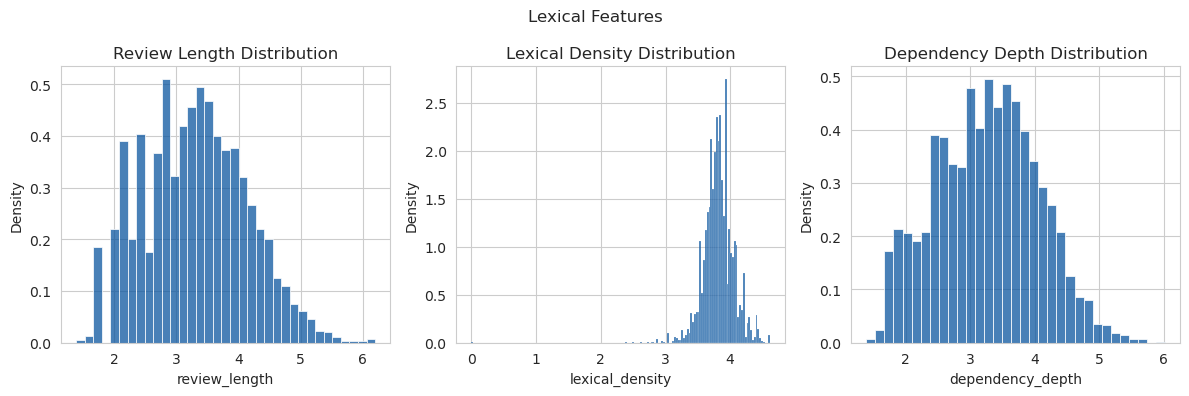

In [15]:
f, ax = plt.subplots(nrows=1,ncols=3, figsize=(12,4))
ax[0] = viz.histogram(data=tqa, x="review_length", ax=ax[0], title="Review Length Distribution")
ax[1]= viz.histogram(data=tqa, x="lexical_density", ax=ax[1], title="Lexical Density Distribution")
ax[2] = viz.histogram(data=tqa, x="dependency_depth", ax=ax[2], title="Dependency Depth Distribution")
f.suptitle(t="Lexical Features")
plt.tight_layout()

## Correlation Plot

<Axes: title={'center': 'AppVoCAI Text Quality Feature Correlation Plot'}>

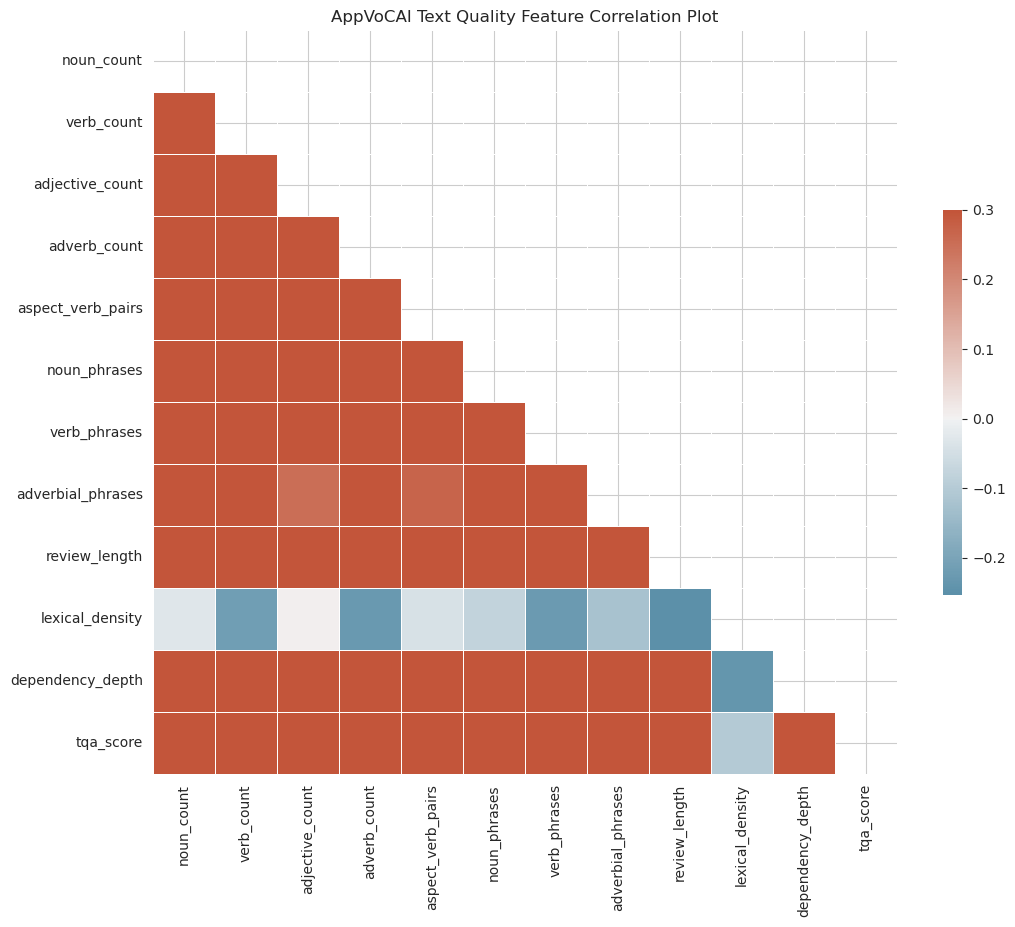

In [ ]:
tqa = dataset.dataframe[TQA_FEATURES]
viz.corrplot(data=tqa, title="AppVoCAI Text Quality Feature Correlation Plot")

## Parts of Speech and TQA Score

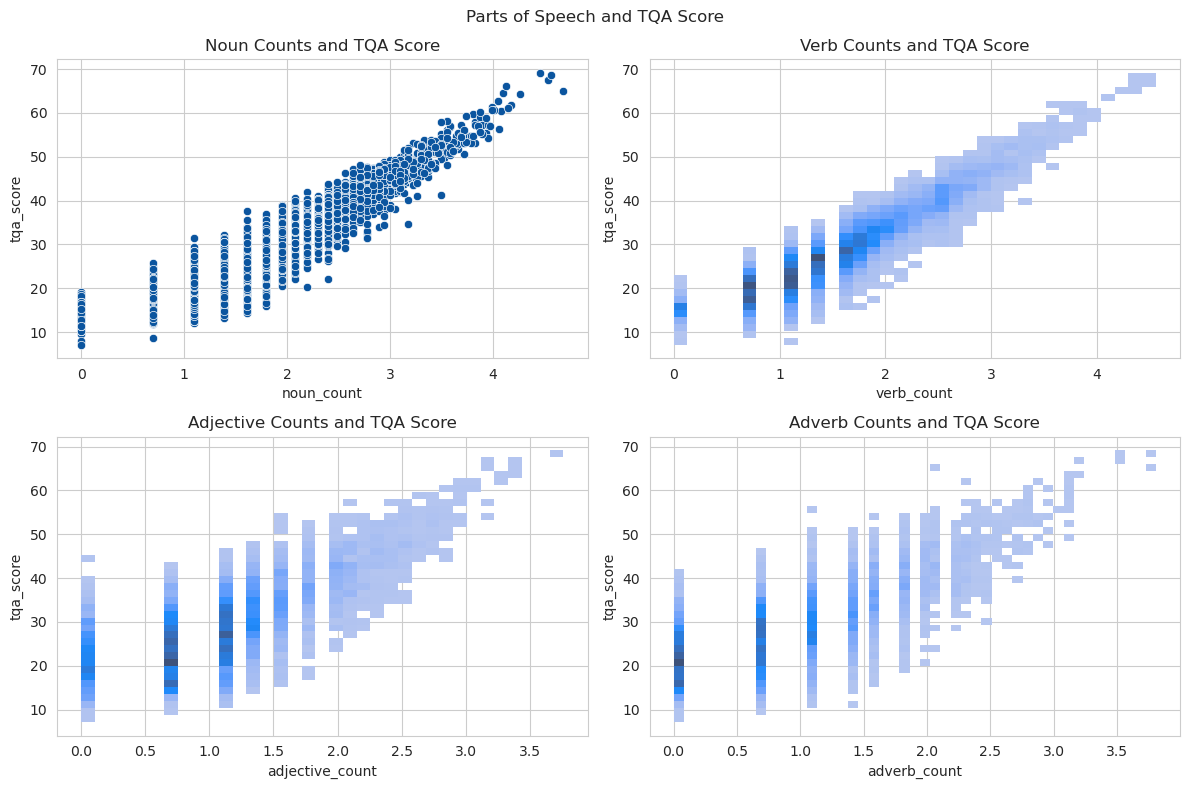

In [16]:
f, ax = plt.subplots(nrows=2,ncols=2, figsize=(12,8))
ax[0,0] = viz.scatterplot(data=tqa, x="noun_count",y="tqa_score", ax=ax[0,0], title="Noun Counts and TQA Score")
ax[0,1]= viz.histogram(data=tqa, x="verb_count", y="tqa_score",ax=ax[0,1], title="Verb Counts and TQA Score")
ax[1,0] = viz.histogram(data=tqa, x="adjective_count", y="tqa_score",ax=ax[1,0], title="Adjective Counts and TQA Score")
ax[1,1] = viz.histogram(data=tqa, x="adverb_count", y="tqa_score",ax=ax[1,1], title="Adverb Counts and TQA Score")
f.suptitle(t="Parts of Speech and TQA Score")
plt.tight_layout()


## Phrases and TQA Score

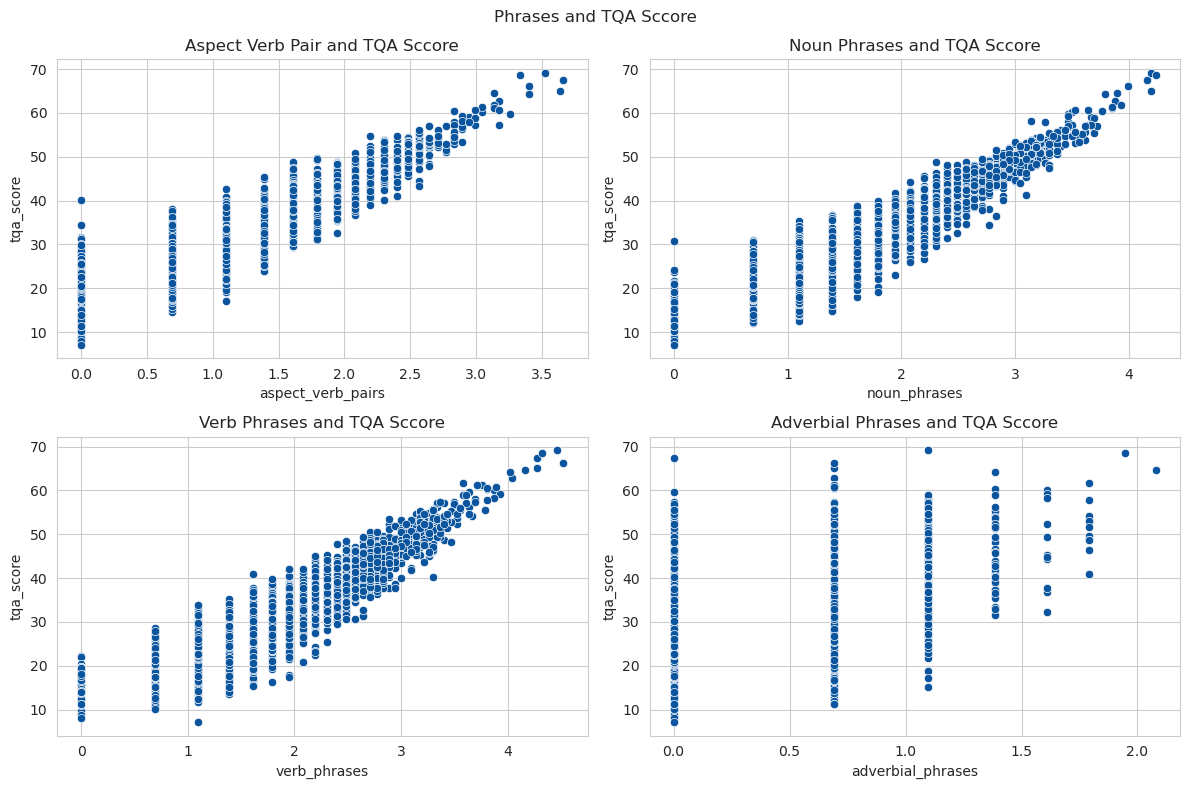

In [ ]:
f, ax = plt.subplots(nrows=2,ncols=2, figsize=(12,8))
ax[0,0] = viz.scatterplot(data=tqa, x="aspect_verb_pairs", y="tqa_score", ax=ax[0,0], title="Aspect Verb Pair and TQA Sccore")
ax[0,1]= viz.scatterplot(data=tqa, x="noun_phrases",y="tqa_score", ax=ax[0,1], title="Noun Phrases and TQA Sccore")
ax[1,0] = viz.scatterplot(data=tqa, x="verb_phrases", y="tqa_score",ax=ax[1,0], title="Verb Phrases and TQA Sccore")
ax[1,1] = viz.scatterplot(data=tqa, x="adverbial_phrases",y="tqa_score", ax=ax[1,1], title="Adverbial Phrases and TQA Sccore")
f.suptitle(t="Phrases and TQA Score")
plt.tight_layout()

## Lexical Features and TQA Scores 

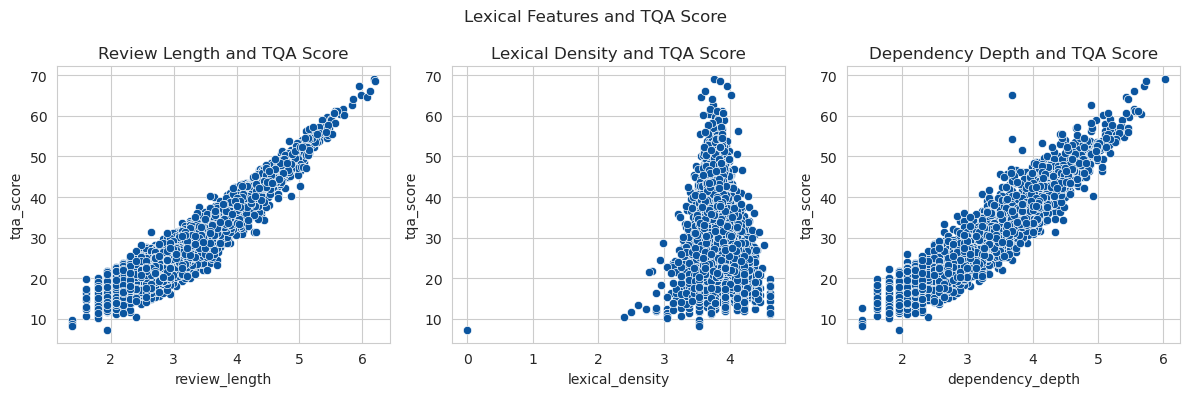

In [19]:
f, ax = plt.subplots(nrows=1,ncols=3, figsize=(12,4))
ax[0] = viz.scatterplot(data=tqa, x="review_length", y="tqa_score", ax=ax[0], title="Review Length and TQA Score")
ax[1]= viz.scatterplot(data=tqa, x="lexical_density",  y="tqa_score",ax=ax[1], title="Lexical Density and TQA Score")
ax[2] = viz.scatterplot(data=tqa, x="dependency_depth", y="tqa_score", ax=ax[2], title="Dependency Depth and TQA Score")
f.suptitle(t="Lexical Features and TQA Score")
plt.tight_layout()